## Setup

In [1]:
# Core libraries
import sys
import os
import json
import numpy as np
from pathlib import Path
from collections import Counter

# MLX for deep learning on Apple Silicon
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Import utilities
from mlx_nlp_utils import print_device_info

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print("📦 MLX Intent Classification is ready!")
print(f"🖥️  MLX version: {mx.__version__}")
print(f"🐍 Python version: {sys.version.split()[0]}")

# Check hardware acceleration
print_device_info()

✅ All libraries imported successfully!
📦 MLX Intent Classification is ready!
🖥️  MLX version: 0.29.4
🐍 Python version: 3.13.7

🖥️  Hardware Acceleration Check:
   Device: Device(gpu, 0)
   ✅ Using Apple Silicon GPU (Metal)
   ℹ️  MLX automatically optimizes for the GPU's Unified Memory.
   ℹ️  Note: While Apple Silicon has an NPU (Neural Engine), MLX primarily
       uses the powerful GPU for general-purpose training tasks like LSTMs.


## Step 1: Load and Explore Data

Let's load our training data and visualize its distribution.

## 📖 Theory: What is Intent Classification?

**Intent Classification** is the task of determining what a user wants to accomplish from their text input. It's the first step in understanding natural language and routing user requests appropriately.

### 🧮 Mathematical Foundation

At its core, our model is a function $f(x)$ that maps a sequence of words to a probability distribution over classes.

**1. The Softmax Function**
To convert the raw output scores (logits) into probabilities that sum to 1, we use the Softmax function:

$$ \sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} $$

Where $z$ is the vector of logits and $K$ is the number of classes.

**2. Cross-Entropy Loss**
To train the model, we measure the difference between the predicted probability distribution and the true label using Cross-Entropy Loss:

$$ L = -\sum_{c=1}^M y_{o,c} \log(p_{o,c}) $$

Where $y$ is the true label (1 for the correct class, 0 otherwise) and $p$ is the predicted probability.

### 🏗️ Architecture Decision: Why LSTM?

We use a **Long Short-Term Memory (LSTM)** network instead of a simple Feed-Forward network or Bag-of-Words model.

*   **The "Why"**: Language is sequential. The meaning of a word depends on the words before it. "Turn *on* the light" vs "Turn *off* the light".
*   **How it works**: LSTMs maintain an internal "cell state" (memory) that passes through time steps. It uses "gates" (Input, Forget, Output) to decide what information to keep or discard.
*   **Pros**: Captures context and word order. Handles variable-length inputs.
*   **Cons**: Slower to train than Transformers (sequential processing prevents parallelization).

### Real-World Analogy
Think of intent classification like a receptionist at a hospital:
- Patient says "I need to see a doctor" → **Medical Appointment** intent
- Patient says "Where is the cafeteria?" → **Information Request** intent  
- Patient says "I want to pay my bill" → **Payment** intent

The receptionist (classifier) routes each person to the right department.

### Our Classification Task
We classify user input into 3 intents for chatbot routing:
- **Greeting**: "Hello", "Hi there", "Good morning"
- **Question**: "What's the time?", "How are you?", "Tell me about..."
- **Command**: "Turn on lights", "Play music", "Set alarm"

In [2]:
# Load sample data
data_file = Path('../data/intent_samples/data.json')

if not data_file.exists():
    print("⚠️ Sample data not found. Run: python scripts/download_datasets.py --samples")
else:
    with open(data_file, 'r') as f:
        data = json.load(f)
    
    texts = data['texts']
    labels = data['labels']
    
    print(f"📊 Dataset Overview:")
    print(f"   Total examples: {len(texts)}")
    print(f"   Unique intents: {len(set(labels))}")
    print(f"   Intents: {set(labels)}")
    print(f"\n📝 Sample data:")
    for i in range(min(5, len(texts))):
        print(f"   '{texts[i]}' → {labels[i]}")

📊 Dataset Overview:
   Total examples: 160
   Unique intents: 3
   Intents: {'question', 'greeting', 'command'}

📝 Sample data:
   'hello' → greeting
   'hi' → greeting
   'hey' → greeting
   'good morning' → greeting
   'good afternoon' → greeting


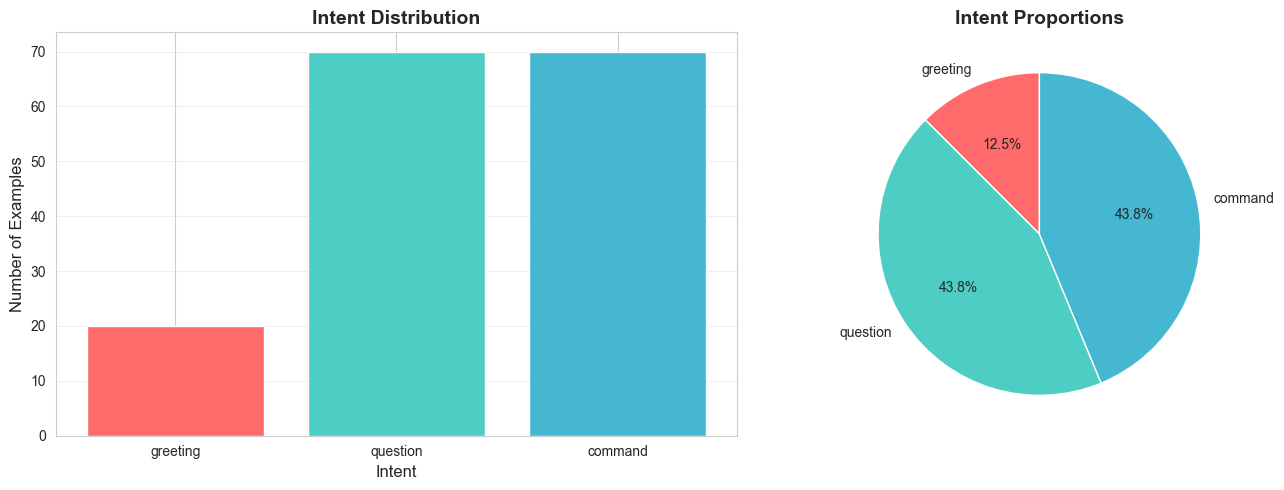

✓ Visualization saved as 'intent_distribution.png'


In [3]:
# Visualize intent distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count intents
intent_counts = Counter(labels)
intents = list(intent_counts.keys())
counts = list(intent_counts.values())

# Bar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax1.bar(intents, counts, color=colors)
ax1.set_xlabel('Intent', fontsize=12)
ax1.set_ylabel('Number of Examples', fontsize=12)
ax1.set_title('Intent Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(counts, labels=intents, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Intent Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('intent_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'intent_distribution.png'")

## Step 2: Data Preprocessing

Convert text to numerical format that the model can process.

In [4]:
# Build vocabulary
print("Building vocabulary...")
vocab = {"<PAD>": 0, "<UNK>": 1}
for text in texts:
    for word in text.lower().split():
        if word not in vocab:
            vocab[word] = len(vocab)

print(f"✓ Vocabulary size: {len(vocab)} words")
print(f"\nSample vocabulary entries:")
for word, idx in list(vocab.items())[:10]:
    print(f"   '{word}' → {idx}")

# Map intents to indices
unique_intents = sorted(set(labels))
intent2idx = {intent: i for i, intent in enumerate(unique_intents)}
print(f"\nIntent mapping:")
for intent, idx in intent2idx.items():
    print(f"   {intent} → {idx}")

Building vocabulary...
✓ Vocabulary size: 106 words

Sample vocabulary entries:
   '<PAD>' → 0
   '<UNK>' → 1
   'hello' → 2
   'hi' → 3
   'hey' → 4
   'good' → 5
   'morning' → 6
   'afternoon' → 7
   'evening' → 8
   'there' → 9

Intent mapping:
   command → 0
   greeting → 1
   question → 2


In [5]:
# Tokenize and pad sequences
max_len = max(len(t.split()) for t in texts)
print(f"Maximum sequence length: {max_len} words")

X = []
for text in texts:
    # Tokenize
    tokens = [vocab.get(word.lower(), vocab["<UNK>"]) for word in text.split()]
    # Pad
    tokens += [vocab["<PAD>"]] * (max_len - len(tokens))
    X.append(tokens)

# Convert to MLX arrays - use explicit names to avoid variable collisions
# X_train: Input features (sequences of word indices)
# y_train: Target labels (intent indices)
X_train = mx.array(X, dtype=mx.int32)
y_train = mx.array([intent2idx[label] for label in labels], dtype=mx.int32)

print(f"\n✓ Prepared {len(X_train)} training examples")
print(f"   Input shape: {X_train.shape}")
print(f"   Output shape: {y_train.shape}")

Maximum sequence length: 7 words

✓ Prepared 160 training examples
   Input shape: (160, 7)
   Output shape: (160,)


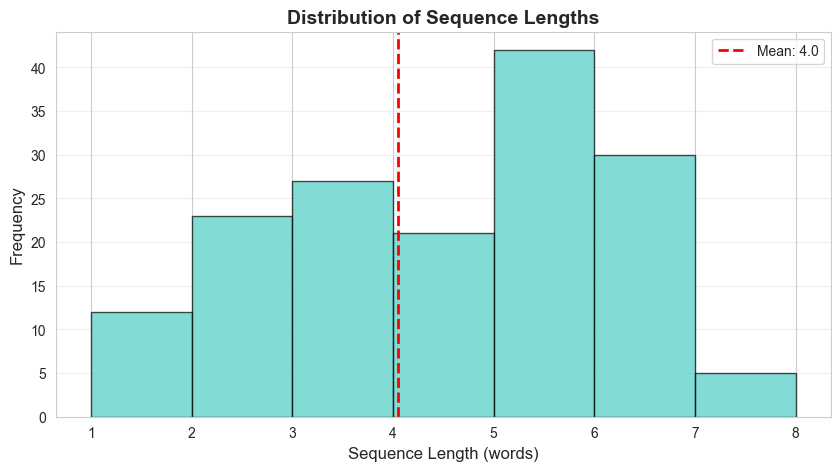

Mean length: 4.0 words
Max length: 7 words


In [6]:
# Visualize sequence lengths
seq_lengths = [len(text.split()) for text in texts]

plt.figure(figsize=(10, 5))
plt.hist(seq_lengths, bins=range(1, max(seq_lengths) + 2), 
         color='#4ECDC4', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(seq_lengths), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(seq_lengths):.1f}')
plt.xlabel('Sequence Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Sequence Lengths', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig('sequence_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean length: {np.mean(seq_lengths):.1f} words")
print(f"Max length: {max(seq_lengths)} words")

## Step 3: Build the Model

Create an LSTM-based intent classifier.

### Model Architecture

Here is the flow of data through our LSTM model:

```mermaid
graph LR
    A[Input Text] --> B(Embedding Layer);
    B --> C(LSTM Layer);
    C --> D(Linear Layer);
    D --> E[Output Class];
    style A fill:#f9f,stroke:#333,stroke-width:2px
    style B fill:#bbf,stroke:#333,stroke-width:2px
    style C fill:#bfb,stroke:#333,stroke-width:2px
    style D fill:#fbf,stroke:#333,stroke-width:2px
    style E fill:#ff9,stroke:#333,stroke-width:2px
```

In [7]:
# Define model architecture
class IntentClassifier(nn.Module):
    """LSTM-based intent classifier"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bias=True)
        self.linear = nn.Linear(hidden_dim, num_classes)
    
    def __call__(self, x):
        # Embed tokens
        embedded = self.embedding(x)
        # Process with LSTM
        lstm_out, _ = self.lstm(embedded)
        # Take last output
        last_output = lstm_out[:, -1, :]
        # Classify
        logits = self.linear(last_output)
        return logits

# Create model
embedding_dim = 32
hidden_dim = 64
num_classes = len(unique_intents)

model = IntentClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes
)

print("✓ Model created!")
print(f"\nArchitecture:")
print(f"   Vocabulary: {len(vocab)} words")
print(f"   Embedding: {embedding_dim} dimensions")
print(f"   LSTM Hidden: {hidden_dim} units")
print(f"   Output Classes: {num_classes}")

# Calculate total parameters - flatten nested dicts
def count_params(params_dict):
    total = 0
    for v in params_dict.values():
        if isinstance(v, dict):
            total += count_params(v)
        else:
            total += v.size
    return total

total_params = count_params(model.parameters())
print(f"\n   Total parameters: {total_params:,}")

✓ Model created!

Architecture:
   Vocabulary: 106 words
   Embedding: 32 dimensions
   LSTM Hidden: 64 units
   Output Classes: 3

   Total parameters: 28,419


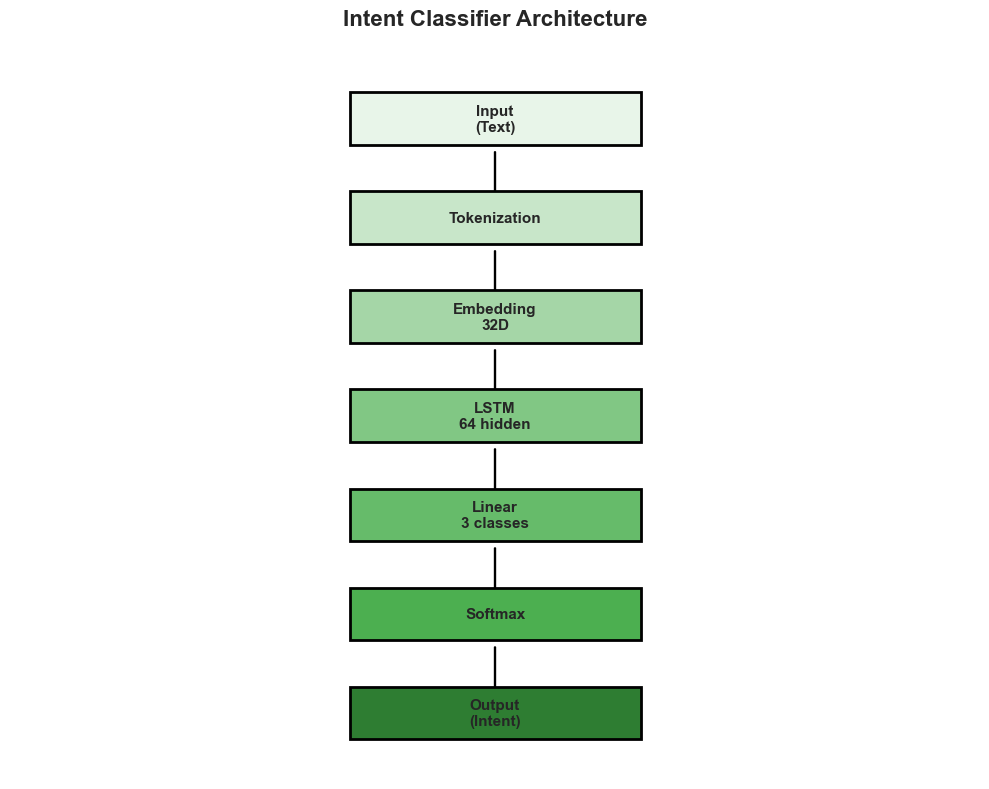

✓ Architecture diagram saved


In [8]:
# Visualize model architecture
fig, ax = plt.subplots(figsize=(10, 8))

# Define layer positions
layers = [
    ('Input\n(Text)', 0.5, 0.9, '#E8F5E9'),
    ('Tokenization', 0.5, 0.75, '#C8E6C9'),
    (f'Embedding\n{embedding_dim}D', 0.5, 0.6, '#A5D6A7'),
    (f'LSTM\n{hidden_dim} hidden', 0.5, 0.45, '#81C784'),
    (f'Linear\n{num_classes} classes', 0.5, 0.3, '#66BB6A'),
    ('Softmax', 0.5, 0.15, '#4CAF50'),
    ('Output\n(Intent)', 0.5, 0.0, '#2E7D32')
]

# Draw boxes and arrows
for i, (label, x, y, color) in enumerate(layers):
    # Draw box
    box = plt.Rectangle((x-0.15, y-0.04), 0.3, 0.08, 
                        facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(box)
    ax.text(x, y, label, ha='center', va='center', 
            fontsize=11, fontweight='bold')
    
    # Draw arrow to next layer
    if i < len(layers) - 1:
        ax.arrow(x, y-0.05, 0, -0.08, head_width=0.03, 
                head_length=0.02, fc='black', ec='black')

ax.set_xlim(0, 1)
ax.set_ylim(-0.1, 1)
ax.axis('off')
ax.set_title('Intent Classifier Architecture', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Architecture diagram saved")

## Step 4: Train the Model

Train the classifier and track performance metrics.

In [9]:
# Training function
def train_model(model, X, y, epochs=30, learning_rate=0.01):
    """Train the intent classifier"""
    
    # 1. Define the loss function
    # This function takes the model and returns a single scalar value (the loss)
    def loss_fn(model):
        logits = model(X)
        return mx.mean(nn.losses.cross_entropy(logits, y))
    
    # 2. Initialize Optimizer
    # Switch to Adam optimizer for better convergence
    # SGD can sometimes get stuck or converge too slowly on this type of problem
    optimizer = optim.Adam(learning_rate=learning_rate)
    
    # 3. Create the value_and_grad function
    # This is MLX's magic. It transforms our loss_fn into a new function that
    # returns BOTH the loss value AND the gradients with respect to the model's parameters.
    loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
    
    losses = []
    accuracies = []
    
    print("Training Intent Classifier...")
    print("-" * 60)
    
    for epoch in range(epochs):
        # 4. Forward and Backward Pass
        # Calculate loss and gradients in one go
        loss, grads = loss_and_grad_fn(model)
        
        # 5. Update Model Parameters
        # Apply the gradients to the model weights using the optimizer
        optimizer.update(model, grads)
        
        # 6. Force Evaluation (CRITICAL STEP IN MLX)
        # MLX is "lazy" - it builds a computation graph but doesn't run it until needed.
        # Without this line, MLX would just build a huge graph in memory without calculating anything.
        # mx.eval() forces execution to update parameters in memory immediately.
        mx.eval(model.parameters(), optimizer.state)
        
        # Calculate accuracy for monitoring
        logits = model(X)
        predictions = mx.argmax(logits, axis=1)
        accuracy = mx.mean(predictions == y).item()
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Accuracy: {accuracy*100:.1f}%")
    
    return model, losses, accuracies

# Train the model
model, losses, accuracies = train_model(model, X_train, y_train, epochs=30)
print("\n✓ Training complete!")

Training Intent Classifier...
------------------------------------------------------------
Epoch   5 | Loss: 0.9298 | Accuracy: 84.4%
Epoch   5 | Loss: 0.9298 | Accuracy: 84.4%
Epoch  10 | Loss: 0.3074 | Accuracy: 87.5%
Epoch  15 | Loss: 0.1528 | Accuracy: 99.4%
Epoch  20 | Loss: 0.0058 | Accuracy: 100.0%
Epoch  25 | Loss: 0.0005 | Accuracy: 100.0%
Epoch  30 | Loss: 0.0002 | Accuracy: 100.0%

✓ Training complete!
Epoch  10 | Loss: 0.3074 | Accuracy: 87.5%
Epoch  15 | Loss: 0.1528 | Accuracy: 99.4%
Epoch  20 | Loss: 0.0058 | Accuracy: 100.0%
Epoch  25 | Loss: 0.0005 | Accuracy: 100.0%
Epoch  30 | Loss: 0.0002 | Accuracy: 100.0%

✓ Training complete!


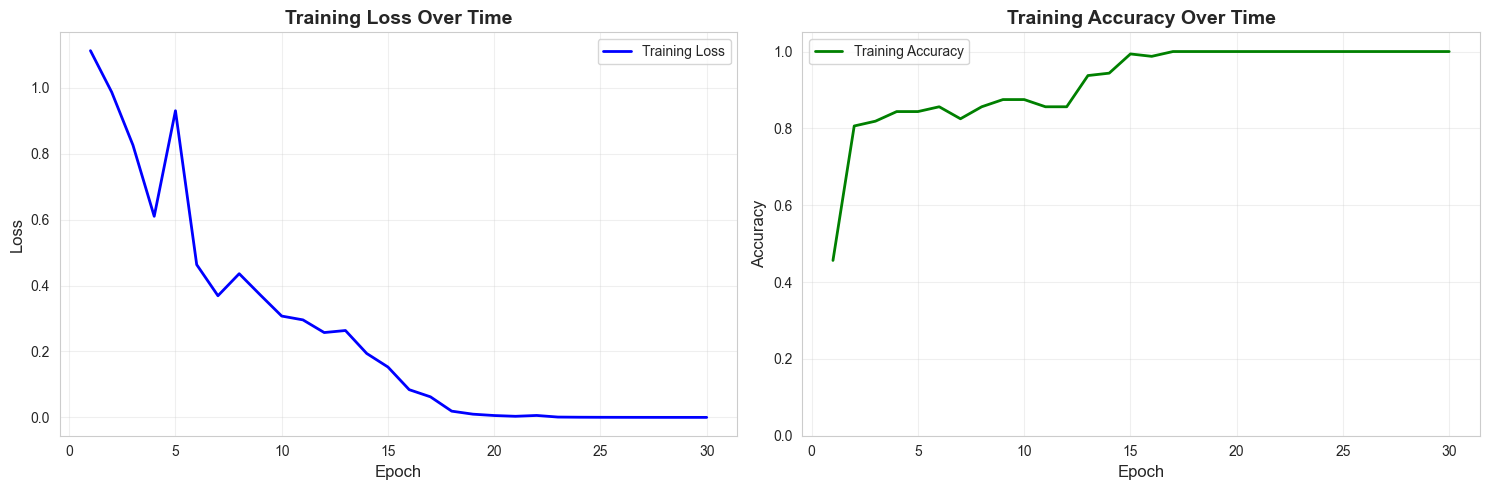


📊 Training Summary:
   Initial Loss: 1.1119
   Final Loss: 0.0002
   Initial Accuracy: 45.63%
   Final Accuracy: 100.00%


In [10]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(losses) + 1)

# Loss curve
ax1.plot(epochs_range, losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(epochs_range, accuracies, 'g-', linewidth=2, label='Training Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Summary:")
print(f"   Initial Loss: {losses[0]:.4f}")
print(f"   Final Loss: {losses[-1]:.4f}")
print(f"   Initial Accuracy: {accuracies[0]:.2%}")
print(f"   Final Accuracy: {accuracies[-1]:.2%}")

## Step 5: Evaluate the Model

Test the model and analyze its predictions.

In [11]:
# Prediction function
def predict_intent(model, text, vocab, intent_names, max_len):
    """Predict intent for a given text"""
    # Tokenize
    tokens = [vocab.get(word.lower(), vocab["<UNK>"]) for word in text.split()]
    # Pad
    tokens += [vocab["<PAD>"]] * (max_len - len(tokens))
    tokens = tokens[:max_len]
    
    # Convert to array
    X_test = mx.array([tokens], dtype=mx.int32)
    
    # Predict
    logits = model(X_test)
    predicted_idx = mx.argmax(logits, axis=1).item()
    confidence = mx.softmax(logits, axis=1)[0, predicted_idx].item()
    
    return intent_names[predicted_idx], confidence

# Test examples
test_examples = [
    "hey there how are you",
    "what is the weather today",
    "please turn on the lights",
    "good morning everyone",
    "can you help me",
    "open the door"
]

print("\n" + "=" * 60)
print("Testing Model Predictions")
print("=" * 60)

predictions = []
confidences = []

for text in test_examples:
    intent, conf = predict_intent(model, text, vocab, unique_intents, max_len)
    predictions.append(intent)
    confidences.append(conf)
    print(f"'{text}'")
    print(f"  → {intent} (confidence: {conf:.1%})\n")


Testing Model Predictions
'hey there how are you'
  → question (confidence: 100.0%)

'what is the weather today'
  → question (confidence: 100.0%)

'please turn on the lights'
  → command (confidence: 100.0%)

'good morning everyone'
  → greeting (confidence: 100.0%)

'can you help me'
  → question (confidence: 99.4%)

'open the door'
  → command (confidence: 100.0%)



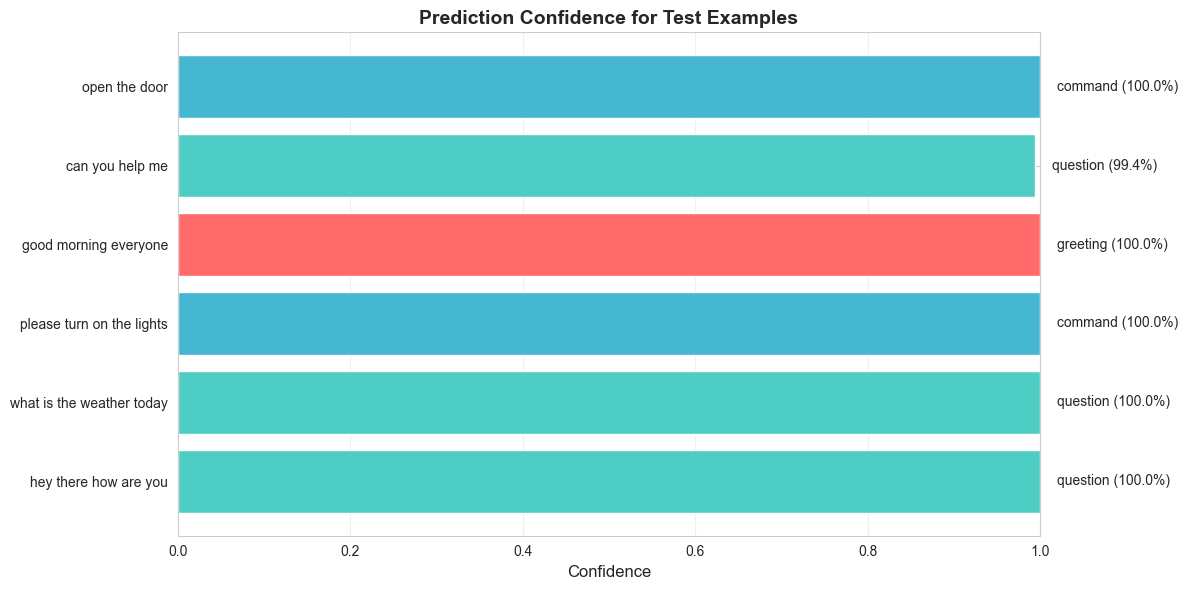

✓ Prediction analysis saved


In [12]:
# Visualize prediction confidence
plt.figure(figsize=(12, 6))

colors_map = {'greeting': '#FF6B6B', 'question': '#4ECDC4', 'command': '#45B7D1'}
colors = [colors_map.get(p, '#95A5A6') for p in predictions]

bars = plt.barh(range(len(test_examples)), confidences, color=colors)
plt.yticks(range(len(test_examples)), 
          [f"{ex[:30]}..." if len(ex) > 30 else ex for ex in test_examples])
plt.xlabel('Confidence', fontsize=12)
plt.title('Prediction Confidence for Test Examples', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

# Add confidence values
for i, (bar, conf, pred) in enumerate(zip(bars, confidences, predictions)):
    plt.text(conf + 0.02, i, f'{pred} ({conf:.1%})', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('prediction_confidence.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Prediction analysis saved")

## Step 6: Confusion Matrix

Analyze which intents the model confuses.

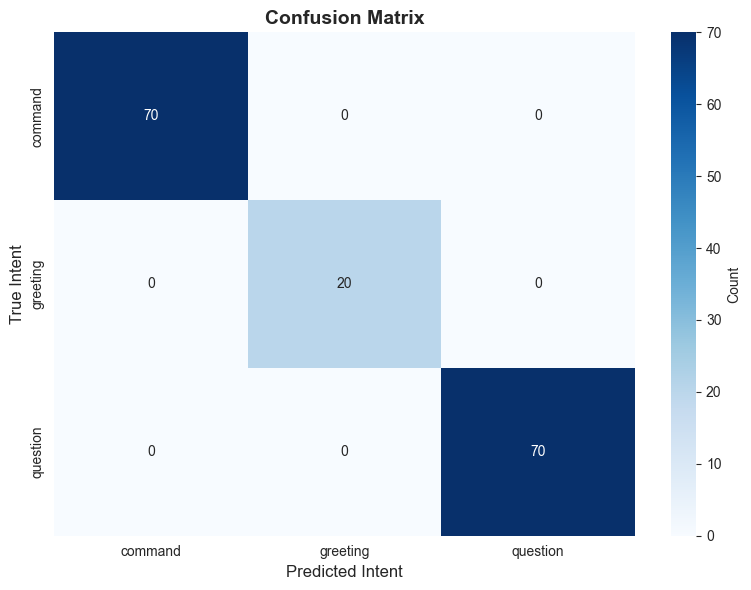


📊 Per-Intent Accuracy:
   command: 100.0%
   greeting: 100.0%
   question: 100.0%


In [13]:
# Generate predictions for all training data
logits = model(X_train)
predictions = mx.argmax(logits, axis=1)

# Create confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train.tolist(), predictions.tolist())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_intents, 
            yticklabels=unique_intents,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Intent', fontsize=12)
plt.ylabel('True Intent', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate per-class accuracy using numpy
print("\n📊 Per-Intent Accuracy:")
y_train_np = y_train.tolist()
predictions_np = predictions.tolist()
for i, intent in enumerate(unique_intents):
    intent_correct = sum(1 for true, pred in zip(y_train_np, predictions_np) if true == i and pred == i)
    intent_total = sum(1 for true in y_train_np if true == i)
    intent_acc = intent_correct / intent_total if intent_total > 0 else 0
    print(f"   {intent}: {intent_acc:.1%}")

## Step 7: Interactive Testing

Try your own custom inputs!

In [14]:
# Interactive prediction function
def test_custom_input(text):
    """Test a custom input and show detailed results"""
    intent, confidence = predict_intent(model, text, vocab, unique_intents, max_len)
    
    # Get all class probabilities
    tokens = [vocab.get(word.lower(), vocab["<UNK>"]) for word in text.split()]
    tokens += [vocab["<PAD>"]] * (max_len - len(tokens))
    tokens = tokens[:max_len]
    X_test = mx.array([tokens], dtype=mx.int32)
    logits = model(X_test)
    probs = mx.softmax(logits, axis=1)[0]
    
    print(f"\n{'=' * 60}")
    print(f"Input: '{text}'")
    print(f"{'=' * 60}")
    print(f"Predicted Intent: {intent}")
    print(f"Confidence: {confidence:.1%}")
    print(f"\nAll Probabilities:")
    for i, (intent_name, prob) in enumerate(zip(unique_intents, probs.tolist())):
        bar = '█' * int(prob * 50)
        print(f"  {intent_name:12s} {prob:6.1%} {bar}")
    print(f"{'=' * 60}")

# Test some examples
test_inputs = [
    "hi how are you doing today",
    "what time is the meeting",
    "turn off the tv please"
]

for test_input in test_inputs:
    test_custom_input(test_input)

# Uncomment to try your own:
# test_custom_input("your text here")


Input: 'hi how are you doing today'
Predicted Intent: question
Confidence: 100.0%

All Probabilities:
  command        0.0% 
  greeting       0.0% 
  question     100.0% █████████████████████████████████████████████████

Input: 'what time is the meeting'
Predicted Intent: question
Confidence: 100.0%

All Probabilities:
  command        0.0% 
  greeting       0.0% 
  question     100.0% █████████████████████████████████████████████████

Input: 'turn off the tv please'
Predicted Intent: command
Confidence: 100.0%

All Probabilities:
  command      100.0% █████████████████████████████████████████████████
  greeting       0.0% 
  question       0.0% 


In [15]:
# Interactive Widget for Testing
import ipywidgets as widgets
from IPython.display import display

def on_button_click(b):
    # Get text from input box
    text = input_box.value
    if not text:
        return
        
    # Predict
    intent, conf = predict_intent(model, text, vocab, unique_intents, max_len)
    
    # Update label
    output_label.value = f"🤖 Prediction: {intent.upper()} ({conf:.1%})"
    
    # Visual feedback color
    if conf > 0.8:
        output_label.style.text_color = 'green'
    elif conf > 0.5:
        output_label.style.text_color = 'orange'
    else:
        output_label.style.text_color = 'red'

# Create widgets
input_box = widgets.Text(
    placeholder='Type a command (e.g., "turn on lights")',
    description='Command:',
    layout=widgets.Layout(width='400px')
)

button = widgets.Button(
    description="Classify",
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    icon='check'
)

output_label = widgets.Label(
    value="Waiting for input...",
    style={'font_weight': 'bold', 'font_size': '14px'}
)

# Link button to function
button.on_click(on_button_click)

# Display UI
print("\n👇 Try it yourself with this interactive widget:")
display(widgets.VBox([
    widgets.HBox([input_box, button]),
    output_label
]))


👇 Try it yourself with this interactive widget:


## Step 8: Training with Real Datasets (Optional)

Scale up to production-ready datasets!

In [16]:
# Instructions for using SNIPS dataset
print("\n" + "=" * 60)
print("Training with Real Datasets")
print("=" * 60)
print("\nTo train on SNIPS dataset (16,000+ examples):")
print("\n1. Download the dataset:")
print("   python ../scripts/download_datasets.py --snips")
print("\n2. Use the Complete Pipeline notebook:")
print("   Open '04_Complete_Pipeline.ipynb' to see how to train on full datasets.")
print("\nExpected Results:")
print("   - Accuracy: 90-95%")
print("   - Training time: 2-5 minutes")
print("   - Production-ready model")
print("\nSNIPS Intents:")
snips_intents = [
    "GetWeather",
    "BookRestaurant",
    "PlayMusic",
    "AddToPlaylist",
    "RateBook",
    "SearchScreeningEvent",
    "SearchCreativeWork"
]
for intent in snips_intents:
    print(f"   - {intent}")
print("=" * 60)


Training with Real Datasets

To train on SNIPS dataset (16,000+ examples):

1. Download the dataset:
   python ../scripts/download_datasets.py --snips

2. Use the Complete Pipeline notebook:
   Open '04_Complete_Pipeline.ipynb' to see how to train on full datasets.

Expected Results:
   - Accuracy: 90-95%
   - Training time: 2-5 minutes
   - Production-ready model

SNIPS Intents:
   - GetWeather
   - BookRestaurant
   - PlayMusic
   - AddToPlaylist
   - RateBook
   - SearchScreeningEvent
   - SearchCreativeWork


## Summary & Next Steps

### What You Learned
✅ How intent classification works  
✅ Building and training LSTM classifiers  
✅ Visualizing model performance  
✅ Evaluating with confusion matrices  
✅ Testing with custom inputs  

### Key Takeaways
- **Embeddings** convert words to vectors that capture meaning
- **LSTMs** process sequences and capture context
- **More data** = better accuracy (sample: 80%, SNIPS: 90-95%)
- **Confidence scores** help you understand model certainty

### Next Notebooks
1. **[Sentiment Analysis](02_Sentiment_Analysis.ipynb)** - Detect emotions
2. **[Text Generation](03_Text_Generation.ipynb)** - Generate responses
3. **[Complete Pipeline](04_Complete_Pipeline.ipynb)** - Build full chatbot

### 🧠 Your Turn: Practice Exercises

1.  **Tweak the Architecture**: 
    *   Change `hidden_dim` from 64 to 128 in the model definition. Does the accuracy improve or does it overfit?
    *   Try changing `embedding_dim` to 100.

2.  **Break the Model**:
    *   Try the input "I am not happy". The model might classify this as a `greeting` or `question` because it hasn't seen negative sentiments. This shows why we need **Sentiment Analysis** (next tutorial!).

3.  **Add a New Intent**:
    *   Add 3-4 examples of a new intent (e.g., "complaint") to the `texts` and `labels` lists at the top of the notebook.
    *   Retrain the model. Can it recognize your new intent?

Great job! 🎉

## ❓ FAQ

**Q: How much data do I need for my own intents?**
A: As a rule of thumb, start with **50-100 examples per intent**. If the intents are very distinct ("Turn on lights" vs "Book a flight"), you need less. If they are subtle ("Check balance" vs "Check transaction history"), you need more.

**Q: What if a user says something that matches two intents?**
A: Our current model uses `Softmax`, which forces a single choice. For multi-intent detection (e.g., "Turn on the lights and play music"), you would use `Sigmoid` activation on the output layer and treat it as a multi-label classification problem.

**Q: Why LSTM and not BERT?**
A: LSTMs are lightweight and fast, making them great for simple command classification on edge devices. BERT is more powerful but computationally heavier. For simple tasks, LSTMs are often "good enough."

## 💭 Closing Thoughts

**Data Quality > Model Architecture**
In production systems, the biggest improvements usually come from cleaning your data, not changing your model. If your model is confused, check your training data—you likely have ambiguous or overlapping examples.

**Architectural Trade-off:**
- **Keyword Matching:** Zero latency, zero cost, but brittle (fails on typos).
- **ML Model (LSTM/BERT):** Robust to phrasing, but requires training and inference compute.
- **LLM (GPT-4):** Extremely smart, but high latency and cost.

For a simple "lights on" command, an LLM is overkill. An LSTM (or even Regex) is often the right engineering choice.